In [1]:
#loading python packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM  #class for LSTM regression
from keras.layers import Dropout
from keras.models import model_from_json
import pickle
import os
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
c:\users\varun\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\varun\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\varun\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#avoid scientific notation while printing float values
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
#reading RUL Life dataset
dataset = pd.read_csv("Dataset/Battery_RUL.csv")
#cleanining dataset to avoid missing values
dataset.fillna(0, inplace = True)
dataset

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.00,2595.30,1151.49,3.67,3.21,5460.00,6755.01,10777.82,1112
1,2.00,7408.64,1172.51,4.25,3.22,5508.99,6762.02,10500.35,1111
2,3.00,7393.76,1112.99,4.25,3.22,5508.99,6762.02,10420.38,1110
3,4.00,7385.50,1080.32,4.25,3.23,5502.02,6762.02,10322.81,1109
4,6.00,65022.75,29813.49,4.29,3.40,5480.99,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
15059,1108.00,770.44,179.52,3.77,3.74,922.78,1412.38,6678.88,4
15060,1109.00,771.12,179.52,3.77,3.74,915.51,1412.31,6670.38,3
15061,1110.00,769.12,179.36,3.77,3.74,915.51,1412.31,6637.12,2
15062,1111.00,773.88,162.37,3.76,3.84,539.38,1148.00,7660.62,1


In [4]:
#preprocess and normalize dataset
temp = dataset.values
Y = temp[:,8:9] #Extract IOT battery life value from dataset 
dataset.drop(['RUL'], axis = 1,inplace=True) #drop index and class label values
dataset.drop(['Cycle_Index'], axis = 1,inplace=True)
dataset = dataset.values


#extracting training X and Y data
X = dataset[:,0:dataset.shape[1]-1]

#class to normalize dataset values
sc = MinMaxScaler(feature_range = (0, 1))


#normalizing or scaling dataset values
X = sc.fit_transform(X)
Y = sc.fit_transform(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print()
print("Preprocessing Completed")
print("Total records found in dataset  : "+str(X.shape[0]))
print("Total features found in dataset : "+str(X.shape[1]))
print()


Preprocessing Completed
Total records found in dataset  : 15064
Total features found in dataset : 6



In [5]:
#splitting dataset into train and test
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Dataset Train & Test Split. 80% dataset used for training and 20% for testing")
print("80% training size : "+str(X_train.shape[0]))
print("20% testing size : "+str(X_test.shape[0]))
print()


Dataset Train & Test Split. 80% dataset used for training and 20% for testing
80% training size : 12051
20% testing size : 3013



In [6]:
mse = []

In [7]:
#function to calculate MSE values
def calculateMSE(algorithm, predict, y_test):
    mse_value = mean_squared_error(y_test,predict)
    mse.append(mse_value)
    print(algorithm+" MSE value : "+str(mse_value))
    print(algorithm+" Accuracy  : "+str(1 - mse_value))
    print()
    predict = sc.inverse_transform(predict)
    predict = predict.ravel()
    labels = y_test.reshape(y_test.shape[0],1)
    labels = sc.inverse_transform(labels)
    labels = labels.ravel()
    labels = labels[0:100]
    predict = predict[0:100]
    for i in range(0,20):
        print(algorithm+" Predicted RUL (Life): "+str(predict[i])+" Original Dataset Life : "+str(labels[i]))
    
    
    #plotting predicted and original RUL values
    plt.plot(labels, color = 'red', label = 'Original RUL')
    plt.plot(predict, color = 'green', label = 'Predicted RUL')
    plt.title(algorithm+' Predicted RUL Graph')
    plt.xlabel('Test Data Size')
    plt.ylabel('Predicted Life')
    plt.legend()
    plt.show()


Tiny LSTM MSE value : 0.004671316529687841
Tiny LSTM Accuracy  : 0.9953286834703121

Tiny LSTM Predicted RUL (Life): 698.2755 Original Dataset Life : 661.0
Tiny LSTM Predicted RUL (Life): 433.5392 Original Dataset Life : 529.0
Tiny LSTM Predicted RUL (Life): 484.04468 Original Dataset Life : 459.0
Tiny LSTM Predicted RUL (Life): 952.4381 Original Dataset Life : 1015.0
Tiny LSTM Predicted RUL (Life): 951.49164 Original Dataset Life : 977.0000000000001
Tiny LSTM Predicted RUL (Life): 299.70987 Original Dataset Life : 100.0
Tiny LSTM Predicted RUL (Life): 602.7286 Original Dataset Life : 590.0
Tiny LSTM Predicted RUL (Life): 219.79938 Original Dataset Life : 227.0
Tiny LSTM Predicted RUL (Life): 601.43445 Original Dataset Life : 556.0
Tiny LSTM Predicted RUL (Life): 865.339 Original Dataset Life : 938.0
Tiny LSTM Predicted RUL (Life): 81.65268 Original Dataset Life : 69.0
Tiny LSTM Predicted RUL (Life): 719.23376 Original Dataset Life : 764.9999999999999
Tiny LSTM Predicted RUL (Life): 1

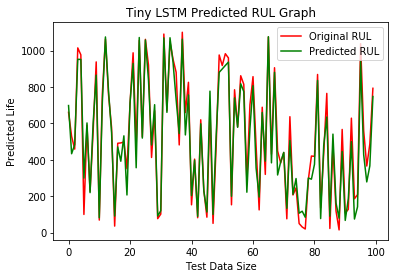

In [8]:
'''
train iot battery life with LSTM and this LSTM can be converted to tiny LSTM 
'''
if os.path.exists('model/model.json'):
    with open('model/model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        lstm = model_from_json(loaded_model_json)
    json_file.close()
    lstm.load_weights("model/model_weights.h5")
    lstm._make_predict_function()   
else:
    #training with LSTM algorithm and saving trained model and LSTM refrence assigned to regression variable
    lstm = Sequential()
    #defining 32 neurons
    lstm.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    #0.2 as the drop out
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = 16, return_sequences = True)) #16 another layer neurons
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = 50, return_sequences = True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = 50))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units = 1))
    lr = Adam(lr = 0.001) #learnining rate
    lstm.compile(optimizer = lr, loss = 'mean_squared_error')
    hist = lstm.fit(X_train, y_train, epochs = 5, batch_size = 16, validation_data=(X_test, y_test))
    lstm.save_weights('model/model_weights.h5')            
    model_json = lstm.to_json()
    with open("model/model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    f = open('model/lstm_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()


#performing prediction on test data    
predict = lstm.predict(X_test)
calculateMSE("Tiny LSTM", predict, y_test)

Tiny DNN MSE value : 0.0024359436044746894
Tiny DNN Accuracy  : 0.9975640563955253

Tiny DNN Predicted RUL (Life): 711.37646 Original Dataset Life : 661.0
Tiny DNN Predicted RUL (Life): 436.42365 Original Dataset Life : 529.0
Tiny DNN Predicted RUL (Life): 468.3285 Original Dataset Life : 459.0
Tiny DNN Predicted RUL (Life): 1038.0767 Original Dataset Life : 1015.0
Tiny DNN Predicted RUL (Life): 1013.69086 Original Dataset Life : 977.0000000000001
Tiny DNN Predicted RUL (Life): 398.89825 Original Dataset Life : 100.0
Tiny DNN Predicted RUL (Life): 603.50226 Original Dataset Life : 590.0
Tiny DNN Predicted RUL (Life): 262.75284 Original Dataset Life : 227.0
Tiny DNN Predicted RUL (Life): 616.8539 Original Dataset Life : 556.0
Tiny DNN Predicted RUL (Life): 935.3549 Original Dataset Life : 938.0
Tiny DNN Predicted RUL (Life): 84.68846 Original Dataset Life : 69.0
Tiny DNN Predicted RUL (Life): 752.09686 Original Dataset Life : 764.9999999999999
Tiny DNN Predicted RUL (Life): 1110.7175 Or

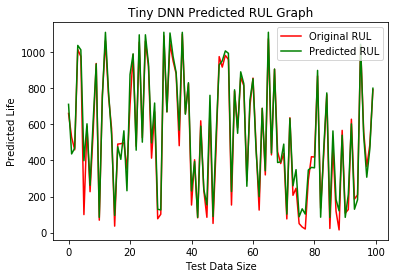

In [9]:
#now training RUL battery IOT data with Deep neural netwworks
X = np.reshape(X, (X.shape[0], (X.shape[1] * X.shape[2])))
X_train = np.reshape(X_train, (X_train.shape[0], (X_train.shape[1] * X_train.shape[2])))
X_test = np.reshape(X_test, (X_test.shape[0], (X_test.shape[1] * X_test.shape[2])))               
if os.path.exists('model/dnn_model.json'):
    with open('model/dnn_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        dnn = model_from_json(loaded_model_json)
    json_file.close()
    dnn.load_weights("model/dnn_model_weights.h5")
    dnn._make_predict_function()   
else:
    #creating neural object with 20 and 10 neurons and learning rate is 0.005
    dnn = Sequential()
    #defining neural network with 20 neurons
    dnn.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
    dnn.add(Dense(10, activation='relu'))#10 neurons
    dnn.add(Dense(1))
    lr = Adam(lr = 0.005) #learning rate
    dnn.compile(optimizer=lr, loss='mean_squared_error')
    hist = dnn.fit(X_train, y_train, epochs = 50, batch_size = 16, validation_data=(X_test, y_test))
    dnn.save_weights('model/dnn_model_weights.h5')            
    model_json = dnn.to_json()
    with open("model/dnn_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    f = open('model/dnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()


#performing prediction on test data using DNN   
predict = dnn.predict(X_test)
calculateMSE("Tiny DNN", predict, y_test)

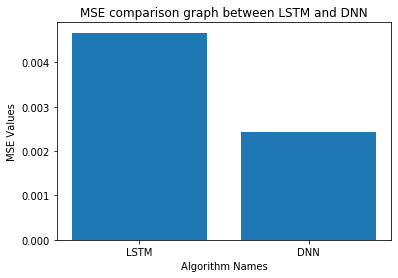

In [10]:
#MSE comparison graph between LSTM and DNN
height = mse
bars = ('LSTM','DNN')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Algorithm Names")
plt.ylabel("MSE Values")
plt.title("MSE comparison graph between LSTM and DNN")
plt.show()

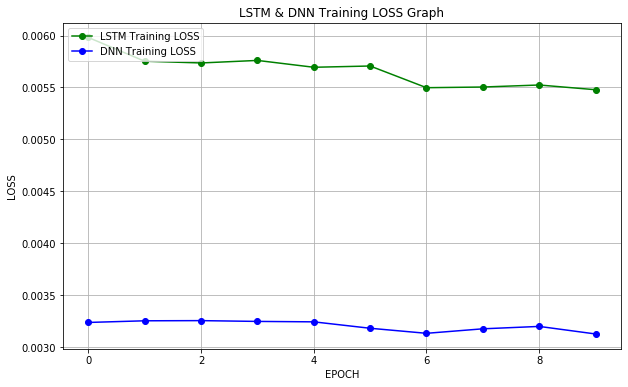

In [11]:
f = open('model/lstm_history.pckl', 'rb')
data = pickle.load(f)
f.close()
lstm_loss = data['loss']
lstm_loss = lstm_loss[40:50]


f = open('model/dnn_history.pckl', 'rb')
data = pickle.load(f)
f.close()
dnn_loss = data['loss']
dnn_loss = dnn_loss[40:50]


plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.plot(lstm_loss, 'ro-', color = 'green')
plt.plot(dnn_loss, 'ro-', color = 'blue')
plt.legend(['LSTM Training LOSS','DNN Training LOSS'], loc='upper left')
plt.title('LSTM & DNN Training LOSS Graph')
plt.show()
